## Similarity-Based Predictive Maintenance Framework for Rotating Machinery

In [1]:
import glob
from scipy.io import loadmat
from numpy import asarray
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
from scipy import signal
import math
import scipy
import re
import os
import pandas as pd
import pywt
from scipy.fftpack import fft
import sys
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.spatial import distance

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Function for FFT

def apply_fft(x, fs, num_samples):
    f = np.linspace(0.0, (fs/2.0), num_samples//2)
    freq_values = fft(x)
    freq_values = 2.0/num_samples * np.abs(freq_values[0:num_samples//2])
    return f, freq_values

In [3]:
# @@@ Function to create dataset from raw vibration signals @@@
# The function processes .mat vibration data files and do segmentation of vibration signals according to 
# desired length of the input segment "num_samples".

# @@@@ Inputs: 
#data_src: path to dataset folders
#req_Key: key to extract vibration data from .mat files
#num_samples:  required length of input vibration samples "number of data points per sample".
#class_: label/class of vibration data

# @@@@ The function returns:
# reference vibration samples "baselines" and  thier labels "baselines_labels"
# test vibration samples "segmented_data" and  thier labels "labels"





def make_dataset(data_src, req_Key, num_samples, class_):
    all_num_segments = []
    pattern = re.compile(req_Key)
    files = glob.glob(data_src)
    files = np.sort(files)
    for file in files:
        data = loadmat(file)
        keysList = [key for key in data]
        for key in keysList:
            if pattern.search(key):
                my_key = key
                drive_end_data = data[my_key] 
                num_segments = np.floor(len(drive_end_data)/num_samples)
                all_num_segments.append(num_segments)
                total_num_segments = sum(all_num_segments)
    L = len(all_num_segments)
    segmented_data = np.empty([int(total_num_segments)-L, num_samples])
    baselines = np.empty([L,num_samples])
    num = 0
    k = 0
    for file in files:
        data = loadmat(file)
        keysList = [key for key in data]
        for key in keysList:
            if pattern.search(key):
                my_key = key
                drive_end_data = data[my_key] 
                num_segments = np.floor(len(drive_end_data)/num_samples)
                for i in range(int(num_segments)):
                    if i == 0:
                        baselines[k,:] = drive_end_data[i*num_samples:(i+1)*num_samples, 0]
                        k = k +1
                    else:
                        segmented_data[num,:] = drive_end_data[i*num_samples:(i+1)*num_samples, 0]
                        num = num + 1
    segmented_data = np.unique(segmented_data, axis= 0)# Remove duplicates
    baselines = np.unique(baselines, axis= 0)# Remove duplicates
    labels = np.ones(len(segmented_data))*class_
    baselines_labels = np.ones(len(baselines))*class_
    return segmented_data, labels, baselines, baselines_labels

In [4]:
# @@@  Function to perforem similarity_based_classification:
# It applies similarity measures between reference samples and test sample.
# The similart measure are: SSIM, Euclidean distance, and cosine similarity.

# @@@@ Inputs: 
#baselines: features of Reference samples
#test_data: features of test samples
#baseline_labels: Labels of Reference samples

# @@@@ The function returns:
#y_pred: SSIM similarity scores of test smaples 
#y_pred2: Cosine similarity  scores of test smaples 
#y_pred3: Euclidean distance similarity  scores of test smaples
#y_ssim: Predicted classes using SSIM
#y_dist: Predicted classes using cosine similarity  scores of test smaples 
#y_dist2: Predicted classes using Euclidean distance

def  similarity_based_classification(baselines,test_data, baseline_labels):
    y_pred = np.empty(len(test_data)) # SSIM similarity scores of test smaples 
    y_pred2 = np.empty(len(test_data)) # Cosine similarity  scores of test smaples 
    y_pred3 = np.empty(len(test_data)) # Euclidean distance similarity  scores of test smaples
    
    y_ssim = np.empty(len(test_data)) # Predicted classes using SSIM
    y_dist = np.empty(len(test_data)) # Predicted classes using cosine similarity  scores of test smaples 
    y_dist2 = np.empty(len(test_data)) # Predicted classes using Euclidean distance
 
    for i in range(len(test_data)):
        s = test_data[i]
        ssim_record = np.empty(len(baselines))
        dist_record = np.empty(len(baselines))
        dist2_record = np.empty(len(baselines))
        for k in range(len(baselines)):
            ssim_record[k]=  ssim(baselines[k], test_data[i]) # SSIM
            dist_record[k] = distance.cosine(baselines[k].reshape(-1), test_data[i].reshape(-1)) # Cosine similaritiy
            dist2_record[k] = np.mean( sum(abs(e1-e2)**2 for e1, e2 in zip( baselines[k], test_data[i] ))**(1/2) ) # Ecludian distance
        y_pred[i] = baseline_labels[int(np.argmax(ssim_record))]
        y_pred2[i] = baseline_labels[int(np.argmin(dist_record))]
        y_pred3[i] = baseline_labels[int(np.argmin(dist2_record))]
        y_ssim[i] = np.max(ssim_record)
        y_dist[i] = np.min(dist_record) 
        y_dist2[i] = np.min(dist2_record)
        
    return y_pred, y_pred2, y_pred3, y_ssim, y_dist, y_dist2

==========================================================================================================================
# Dataset Creatioin:
=========================================================================================================================== 

## Grouping vibration signals in required folders to  generate datasets
Link to download CWRU dataset: https://engineering.case.edu/bearingdatacenter <br>
After downloading the dataset, vibration signals to be grouped according to their operational conditions/properties* in 10 folders (corresponding to number of operational classes in the dataset: 1 normal class and 9 faulty classes) with below folder names:

1.	12K_DE_Normal 
2.	12k_DE_IRFault_0.007
3.	12k_DE_IRFault_0.014
4.	12k_DE_IRFault_0.021
5.	12k_DE_BallFault_0.007
6.	12k_DE_BallFault_0.014
7.	12k_DE_BallFault_0.021
8.	12k_DE_ORFault_0.007
9.	12k_DE_ORFault_0.014
10.	12k_DE_ORFault_0.021

*12k = sampling rate of vibration signals <br>
*DE= Drive End vibration data <br>
*IRFault = Inner Race faults <br>
*BallFault = Ball faults <br>
*ORFault = Outer Race faults <br>
*0.014/0.021/0.007= fault diameter <br>


In [5]:
fs = 12000; # Sampling rate ( sample/second) of data collection
num_samples = 2000 # Set required length of input vibration samples "number of data points per sample".
Key = "_DE_time" # key to extract  Drive End (DE) vibration data from .mat files

In [6]:
data_path = (r"D:\Coding\Datasets\CWRU_dataset") # path were the folders contain vibration signals are located.

cls_1 = '12K_DE_Normal/*'; cls_2 = '12k_DE_IRFault_0.007/*'; cls_3 = '12k_DE_IRFault_0.014/*'; 
cls_4 = '12k_DE_IRFault_0.021/*'; cls_5 = '12k_DE_BallFault_0.007/*'
cls_6 = '12k_DE_BallFault_0.014/*'; cls_7 = '12k_DE_BallFault_0.021/*'
cls_8 = '12k_DE_ORFault_0.007/*'; cls_9 = '12k_DE_ORFault_0.014/*'; cls_10 ='12k_DE_ORFault_0.021/*'

norm, y_norm, norm_baselines, y_norm_baseline = make_dataset(os.path.join(data_path, cls_1), Key, num_samples, 1)
defc1, y_defc1, defc1_baslines, y_defc1_baseline  = make_dataset(os.path.join(data_path, cls_2), Key, num_samples, 2)
defc2, y_defc2, defc2_baslines, y_defc2_baseline = make_dataset(os.path.join(data_path, cls_3), Key, num_samples, 3)
defc3, y_defc3, defc3_baslines, y_defc3_baseline = make_dataset(os.path.join(data_path, cls_4), Key, num_samples, 4)
defc4, y_defc4, defc4_baslines, y_defc4_baseline = make_dataset(os.path.join(data_path, cls_5), Key, num_samples, 5)
defc5, y_defc5, defc5_baslines, y_defc5_baseline = make_dataset(os.path.join(data_path, cls_6), Key, num_samples, 6)
defc6, y_defc6, defc6_baslines, y_defc6_baseline = make_dataset(os.path.join(data_path, cls_7), Key, num_samples, 7)
defc7, y_defc7, defc7_baslines, y_defc7_baseline = make_dataset(os.path.join(data_path, cls_8), Key, num_samples, 8)
defc8, y_defc8, defc8_baslines, y_defc8_baseline = make_dataset(os.path.join(data_path, cls_9), Key, num_samples, 9)
defc9, y_defc9, defc9_baslines, y_defc9_baseline = make_dataset(os.path.join(data_path, cls_10), Key, num_samples, 10)
print('Class 1 features shape:', norm.shape); print('Class 1 labels shape:', y_norm.shape)
print('Class 2 features shape:', defc1.shape); print('Class 2 labels shape:', y_defc1.shape)
print('Class 3 features shape:', defc2.shape); print('Class 3 labels shape:', y_defc2.shape)
print('Class 4 features shape:', defc3.shape); print('Class 4 labels shape:', y_defc3.shape)
print('Class 5 features shape:', defc4.shape); print('Class 5 labels shape:', y_defc4.shape)
print('Class 6 features shape:', defc5.shape); print('Class 6 labels shape:', y_defc5.shape)
print('Class 7 features shape:', defc6.shape); print('Class 7 labels shape:', y_defc6.shape)
print('Class 8 features shape:', defc7.shape); print('Class 8 labels shape:', y_defc7.shape)
print('Class 9 features shape:', defc8.shape); print('Class 9 labels shape:', y_defc8.shape)
print('Class 10 features shape:', defc9.shape); print('Class 10 labels shape:', y_defc9.shape)

Class 1 features shape: (842, 2000)
Class 1 labels shape: (842,)
Class 2 features shape: (238, 2000)
Class 2 labels shape: (238,)
Class 3 features shape: (236, 2000)
Class 3 labels shape: (236,)
Class 4 features shape: (237, 2000)
Class 4 labels shape: (237,)
Class 5 features shape: (237, 2000)
Class 5 labels shape: (237,)
Class 6 features shape: (238, 2000)
Class 6 labels shape: (238,)
Class 7 features shape: (238, 2000)
Class 7 labels shape: (238,)
Class 8 features shape: (238, 2000)
Class 8 labels shape: (238,)
Class 9 features shape: (237, 2000)
Class 9 labels shape: (237,)
Class 10 features shape: (238, 2000)
Class 10 labels shape: (238,)


In [7]:
test_data = np.concatenate( (norm, defc1, defc2, defc3, defc4, defc5, defc6, defc7, defc8,  defc9 ) , axis=0, out=None)
print("Test samples shape:", test_data.shape )
y_test = np.concatenate( (y_norm, y_defc1, y_defc2, y_defc3, y_defc4, y_defc5, 
                          y_defc6, y_defc7, y_defc8, y_defc9  ), axis=0, out=None)
#Shuffle test samples
df = pd.DataFrame(data=test_data)
df['labels'] = y_test
dff = df
df = df.sample(frac = 1)
y_test = df['labels'].to_numpy()
test_data = df.drop(['labels'], axis=1).to_numpy()


baselines = np.concatenate( (norm_baselines, defc1_baslines, defc2_baslines, defc3_baslines, defc4_baslines, defc5_baslines, 
                     defc6_baslines, defc7_baslines, defc8_baslines,  defc9_baslines ) , axis=0, out=None)
print("Baselines samples shape:", baselines.shape )
baselines_labels = np.concatenate( (y_norm_baseline, y_defc1_baseline, y_defc2_baseline, y_defc3_baseline, 
                                    y_defc4_baseline, y_defc5_baseline, y_defc6_baseline, y_defc7_baseline,
                                    y_defc8_baseline, y_defc9_baseline), axis=0, out=None)


X = np.concatenate( (test_data, baselines) , axis=0, out=None) # Nummpy array contians test [samples:reference labels] for feature extraction
print(X.shape)

Test samples shape: (2979, 2000)
Baselines samples shape: (40, 2000)
(3019, 2000)


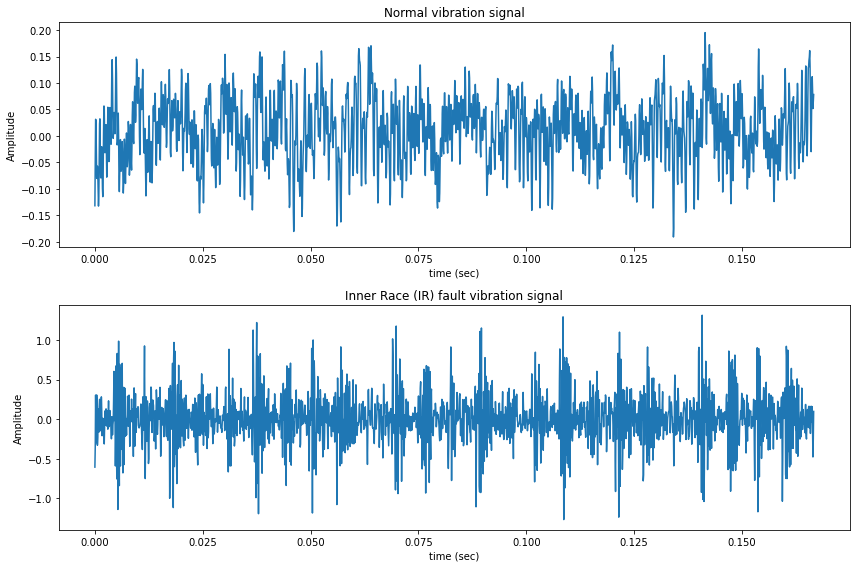

In [8]:
# Plot a normal vibration sample and an abnormal vibration sample

time = np.arange(0.0, len(norm[10]), 1.0)/fs
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(time, norm[10])
plt.xlabel('time (sec)')
plt.ylabel('Amplitude')
plt.title("Normal vibration signal")
plt.subplot(2, 1, 2)
plt.plot(time, defc1[10])
plt.xlabel('time (sec)')
plt.ylabel('Amplitude')
plt.title("Inner Race (IR) fault vibration signal")
plt.tight_layout()
plt.show()

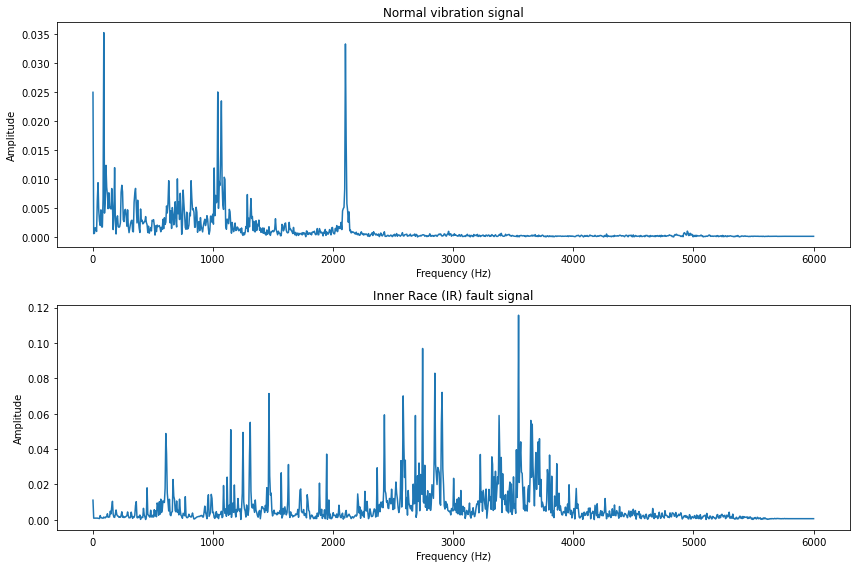

In [9]:
# Obtain and plot FFT for normal and faulty operation conditions


f_normal, fft_normal = apply_fft(norm[0], fs, num_samples)
f_faulty, fft_faulty = apply_fft(defc1[0], fs, num_samples)

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(f_normal, fft_normal)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title("Normal vibration signal")
plt.subplot(2, 1, 2)
plt.plot(f_faulty, fft_faulty)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title("Inner Race (IR) fault signal")
plt.tight_layout()
plt.show()

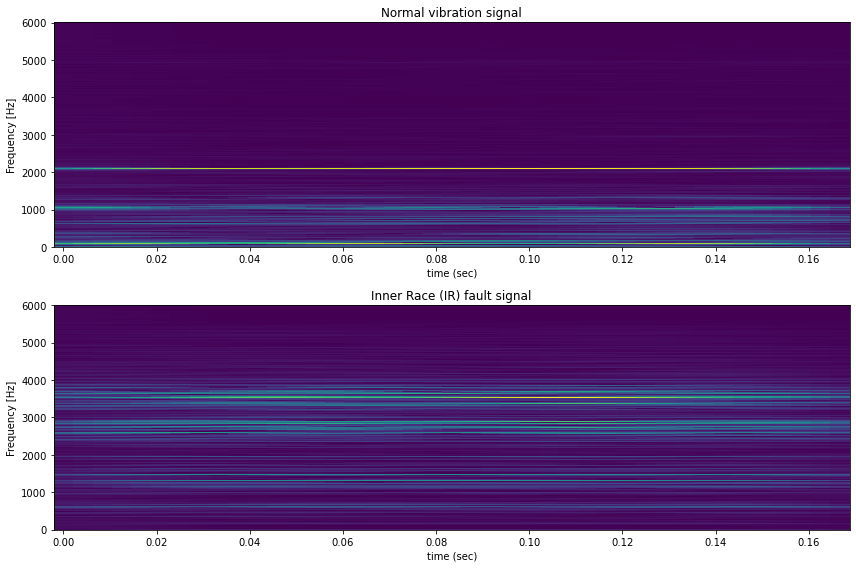

In [10]:
# Obtain and plot STFT for normal and faulty operation conditions


f1, t1, Z_normal = signal.stft(norm[0], fs, window='hamming', 
                                 nperseg=1000, noverlap= 950 , nfft=1028)

f2, t2, Z_faluty = signal.stft(defc1[0], fs, window='hamming', 
                                  nperseg=1000, noverlap= 950 , nfft=1028)
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.pcolormesh(t1, f1, np.abs(Z_normal))
plt.ylabel('Frequency [Hz]')
plt.xlabel('time (sec)')
plt.title("Normal vibration signal")
plt.subplot(2, 1, 2)
plt.pcolormesh(t2, f2, np.abs(Z_faluty))
plt.ylabel('Frequency [Hz]')
plt.xlabel('time (sec)')
plt.title("Inner Race (IR) fault signal")
plt.tight_layout()
plt.show()



==========================================================================================================================
# Feature Extraction:
=========================================================================================================================== 

In [11]:
# Note: Here, a noise-free scenario is considered.

# FFT features extraction:
fft_z = []
for i in range(len(X)):
    f, z = apply_fft(X[i], fs, num_samples)
    fft_z.append(np.squeeze(np.asarray ( abs(z) ) ) )
fft_features = np.asarray(fft_z, dtype="float")
print('FFT features shape:', fft_features.shape)

# STFT features extraction:
stft_z = []
for i in range(len(X)):
    f, t, z = signal.stft(X[i], fs, window='hamming', nperseg=(num_samples/2), noverlap=int( 0.95*(num_samples/2) ), nfft=1028)
    stft_z.append(np.squeeze(np.asarray ( abs(z) ) ) )
stft_features = np.asarray(stft_z, dtype="float")
print('STFT features shape:', stft_features.shape)

FFT features shape: (3019, 1000)
STFT features shape: (3019, 515, 41)


In [12]:
# Select feature type: FFT features or STFT features
features =  fft_features # ====>  fft_features / stft_features 

==========================================================================================================================
# Similarity-Based Classification:
=========================================================================================================================== 

In [13]:
# Separating features of test samples and reference samples and preparing for Similarity-based classification 

test_samples = features[:len(test_data)]
print("Test samples size;", test_samples.shape)
baseline_samples = features[len(test_data):]
print("Reference samples size;", baseline_samples.shape)
baselines_df = pd.DataFrame(data= baseline_samples.reshape(len(baseline_samples),-1) )
baselines_df['labels']= baselines_labels

# Averaging reference samples based on thier classes;
# Since each class involves 4 different motor speeds. Refers to the paper for more details.
baselines_features = baselines_df.groupby('labels').mean().to_numpy()
y_ref_true = np.unique( baselines_labels, axis= 0)


if np.sum(features) == np.sum(stft_features): # Reshape STFT features:
    w, h = test_samples[0].shape
    baselines_features = baselines_features.reshape(len(y_ref_true), w, h )
    
print("Averaged Reference samples shape;", baselines_features.shape)

Test samples size; (2979, 1000)
Reference samples size; (40, 1000)
Averaged Reference samples shape; (10, 1000)


In [14]:
# Similarity-based classification
y_pred_ssim, y_pred_cos, y_pred_Ecl, ssim_score, cos_score, Ecl_score = similarity_based_classification(baselines_features, 
                                                                                               test_samples, y_ref_true)

==========================================================================================================================
# Performance Metrics:
=========================================================================================================================== 

In [15]:
# SSIM
y_predicted = y_pred_ssim
accuracy =accuracy_score(y_test, y_predicted) 
conf_mat =confusion_matrix(y_test, y_predicted)
print("Accuracy:", accuracy*100, "%")
print("Confusion Matrix:")
print(conf_mat)

Accuracy: 99.39577039274926 %
Confusion Matrix:
[[842   0   0   0   0   0   0   0   0   0]
 [  0 238   0   0   0   0   0   0   0   0]
 [  0   0 236   0   0   0   0   0   0   0]
 [  0   0   0 237   0   0   0   0   0   0]
 [  0   0   0   0 237   0   0   0   0   0]
 [  0   0   0   0   0 231   5   0   2   0]
 [  0   0   0   0  11   0 227   0   0   0]
 [  0   0   0   0   0   0   0 238   0   0]
 [  0   0   0   0   0   0   0   0 237   0]
 [  0   0   0   0   0   0   0   0   0 238]]


In [16]:
# Cosine similarity
y_predicted = y_pred_cos
accuracy =accuracy_score(y_test, y_predicted) 
conf_mat =confusion_matrix(y_test, y_predicted)
print("Accuracy:", accuracy*100, "%")
print("Confusion Matrix:")
print(conf_mat)

Accuracy: 99.59718026183283 %
Confusion Matrix:
[[842   0   0   0   0   0   0   0   0   0]
 [  0 238   0   0   0   0   0   0   0   0]
 [  0   0 228   0   0   0   0   0   0   8]
 [  0   0   0 237   0   0   0   0   0   0]
 [  0   0   0   0 237   0   0   0   0   0]
 [  0   0   0   0   0 238   0   0   0   0]
 [  0   0   0   0   4   0 234   0   0   0]
 [  0   0   0   0   0   0   0 238   0   0]
 [  0   0   0   0   0   0   0   0 237   0]
 [  0   0   0   0   0   0   0   0   0 238]]


In [17]:
# Euclidean distance
y_predicted = y_pred_Ecl
accuracy =accuracy_score(y_test, y_predicted) 
conf_mat =confusion_matrix(y_test, y_predicted)
print("Accuracy:", accuracy*100, "%")
print("Confusion Matrix:")
print(conf_mat)

Accuracy: 99.36220208123532 %
Confusion Matrix:
[[842   0   0   0   0   0   0   0   0   0]
 [  0 238   0   0   0   0   0   0   0   0]
 [  0   0 236   0   0   0   0   0   0   0]
 [  0   0   0 237   0   0   0   0   0   0]
 [  0   0   0   0 236   0   1   0   0   0]
 [  0   0   0   0   0 229   1   0   8   0]
 [  0   0   0   0   7   2 229   0   0   0]
 [  0   0   0   0   0   0   0 238   0   0]
 [  0   0   0   0   0   0   0   0 237   0]
 [  0   0   0   0   0   0   0   0   0 238]]
